In [1]:
from pymongo import MongoClient
import pandas as pd
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import re
import matplotlib.pyplot as plt
import scipy
from pymatgen.io.cif import CifParser
import ase
import jax.numpy as jnp
import numpy as np
from sklearn.cluster import KMeans
import torch
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
import src.spectra as spectra
import warnings
warnings.filterwarnings("ignore")

client = MongoClient()
db = client['spectra_database']
# collection = db['mp_AgS_bispectra_lmax_4_min_dist_cutoff']
collection = db['csd_AgS_bispectra_lmax_4_min_dist_cutoff']
data = collection.find()
df = pd.DataFrame(list(data))
df = df.drop('_id', axis=1)


In [2]:
df.head()

,cif_name,formula,site_index,site_element,local_geometry,local_elements,bispectrum
0,SAGGIU.cif,Ag112 P16 H1320 Pt4 W24 C1008 S72 O76,0,Ag,"[[-1.0634174346923828, -0.3351173400878906, -2...",[S],"[0.007802853360772133, 0.0234085563570261, 0.0..."
1,SAGGIU.cif,Ag112 P16 H1320 Pt4 W24 C1008 S72 O76,1,Ag,"[[1.0634193420410156, -0.3351173400878906, 2.2...",[S],"[0.007802862208336592, 0.02340858243405819, 0...."
2,SAGGIU.cif,Ag112 P16 H1320 Pt4 W24 C1008 S72 O76,2,Ag,"[[1.0634183883666992, 0.3351168632507324, 2.22...",[S],"[0.007802856620401144, 0.023408567532896996, 0..."
3,SAGGIU.cif,Ag112 P16 H1320 Pt4 W24 C1008 S72 O76,3,Ag,"[[-1.0634183883666992, 0.3351173400878906, -2....",[S],"[0.007802858017385006, 0.02340857684612274, 0...."
4,SAGGIU.cif,Ag112 P16 H1320 Pt4 W24 C1008 S72 O76,4,Ag,"[[0.9297313690185547, -2.150045394897461, 0.84...",[S],"[0.007787936832755804, 0.023363810032606125, 0..."


In [3]:
len(set(df.cif_name))

3096

In [4]:
AgS_only = df[df['local_elements'].apply(lambda x: len(set(x)) == 1)]
AgS_only_bispectra = list(AgS_only.bispectrum)
AgS_others = df[df['local_elements'].apply(lambda x: len(set(x)) != 1)]
AgS_others_bispectra = list(AgS_others.bispectrum)


In [5]:
len(AgS_only_bispectra)

41428

  0%|          | 0/9 [00:00<?, ?it/s]


3D_PCA_plot.html


ValueError: Invalid CIF file with no structures!

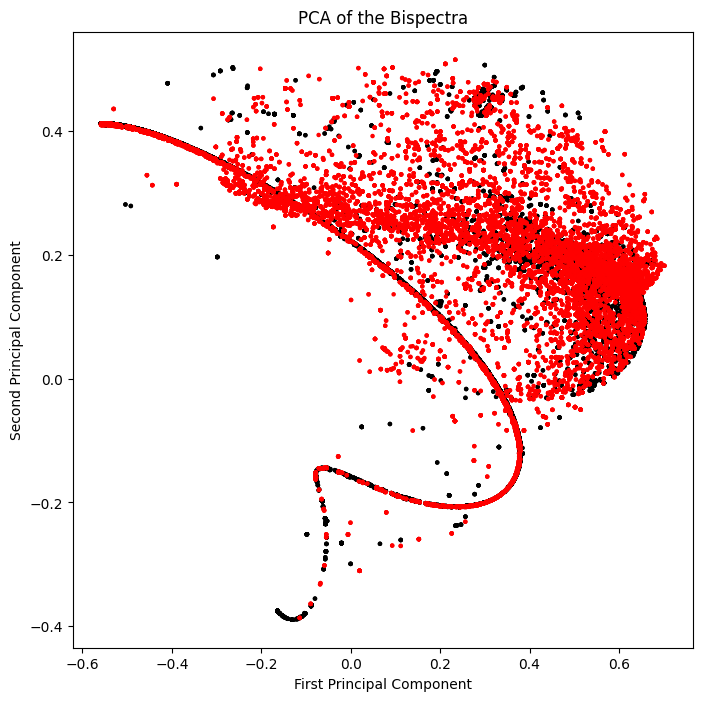

In [6]:
for i in range(len(AgS_only_bispectra)):
    AgS_only_bispectra[i] = AgS_only_bispectra[i] / np.linalg.norm(AgS_only_bispectra[i])

for i in range(len(AgS_others_bispectra)):
    AgS_others_bispectra[i] = AgS_others_bispectra[i] / np.linalg.norm(AgS_others_bispectra[i])

kmeans = KMeans(n_clusters=8, n_init=10, random_state=0).fit(AgS_only_bispectra)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(AgS_only_bispectra)
pca_result_others = pca.transform(AgS_others_bispectra)

color_labels = ['black' for label in kmeans.labels_]
color_labels_others = ['red' for _ in AgS_others_bispectra]

plt.figure(figsize=(8, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=color_labels, s=5)
plt.scatter(pca_result_others[:, 0], pca_result_others[:, 1], c=color_labels_others, s=5)
plt.title('PCA of the Bispectra')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

bispectrum = spectra.Spectra(neighbors=["S", "Se", "Te"], cutoff=spectra.min_dist_cutoff())
os.chdir('/Users/tphung/Dropbox (MIT)/repos/pyspectra/cifs/mochas/')
cif_filenames = os.listdir()
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
markers = ['*', 'v', '^', '<', '>', 's', 'p', 'o']
legend_labels = set()
for i, cif_filename in enumerate(tqdm(cif_filenames)):
    print(cif_filename)
    cif_filepath = os.path.join(os.getcwd(), cif_filename)
    bispectrum.load_cif(cif_filepath)
    structure = bispectrum.get_structure()
    ag_sites = [i for i, site in enumerate(structure) if site.species_string == "Ag"]
    color = colors[i % len(colors)]
    marker = markers[i % len(markers)]
    for ag_site in ag_sites:
        bispectrum.load_cif(cif_filepath)
        spectrum = bispectrum.compute_atom_spectra(ag_site)
        if spectrum is not None:
            spectrum = spectrum / np.linalg.norm(spectrum)
            pca_result = pca.transform([spectrum])[0]
            plt.scatter(pca_result[0], pca_result[1], marker=marker, s=300, alpha=0.5, color=color)  # Increased size from 200 to 500
            if color not in legend_labels:
                plt.scatter([], [], marker=marker, s=500, alpha=0.5, label=f"{cif_filename}", color=color)  # Increased size from 200 to 500
                legend_labels.add(color)
plt.legend()  # Added this line to show the legend

In [ ]:
# Linear
linear = jnp.array([
    [1, 0, 0],
    [-1, 0, 0]
])

# Trigonal planar
trigonal_planar = jnp.array([
    [1, 0, 0],
    [-0.5, jnp.sqrt(3)/2, 0],
    [-0.5, -jnp.sqrt(3)/2, 0]
])

# Bent (assume 120 degrees)
bent_120 = jnp.array([
    [1, 0, 0],
    [-0.5, jnp.sqrt(3)/2, 0]
])

# Tetrahedral
tetrahedral = jnp.array([
    [0, 0, 1],
    [0.943, 0, -0.333],
    [-0.471, 0.816, -0.333],
    [-0.471, -0.816, -0.333]
])

# Seesaw
seesaw = jnp.array([
    [1, 0, 0],
    [-1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])

# T-shaped
t_shaped = jnp.array([
    [1, 0, 0],
    [-1, 0, 0],
    [0, 1, 0]
])

# Octahedral
octahedral = jnp.array([
    [1, 0, 0],
    [-1, 0, 0],
    [0, 1, 0],
    [0, -1, 0],
    [0, 0, 1],
    [0, 0, -1]
])

common_geometries = {
    'linear': linear,
    'trigonal_planar': trigonal_planar,
    'bent_120': bent_120,
    'tetrahedral': tetrahedral,
    't_shaped': t_shaped,
    'octahedral': octahedral
}

bispectrum = spectra.Spectra()
for label, geometry in common_geometries.items():
    spectrum = np.array(bispectrum.compute_geometry_spectra(geometry))
    common_geometries[label] = spectrum / np.linalg.norm(spectrum)

In [ ]:
trigonal_prism = jnp.array([
    [jnp.cos(jnp.pi/6), 0, -jnp.sin(jnp.pi/6)],
    [-jnp.cos(jnp.pi/6)*jnp.cos(jnp.pi/3), jnp.cos(jnp.pi/6)*jnp.sin(jnp.pi/3), -jnp.sin(jnp.pi/6)],
    [-jnp.cos(jnp.pi/6)*jnp.cos(jnp.pi/3), -jnp.cos(jnp.pi/6)*jnp.sin(jnp.pi/3), -jnp.sin(jnp.pi/6)],
    [-jnp.cos(jnp.pi/6), 0, jnp.sin(jnp.pi/6)],
    [jnp.cos(jnp.pi/6)*jnp.cos(jnp.pi/3), -jnp.cos(jnp.pi/6)*jnp.sin(jnp.pi/3), jnp.sin(jnp.pi/6)],
    [jnp.cos(jnp.pi/6)*jnp.cos(jnp.pi/3), jnp.cos(jnp.pi/6)*jnp.sin(jnp.pi/3), jnp.sin(jnp.pi/6)]
])

spectra.visualize_geometry(trigonal_prism)

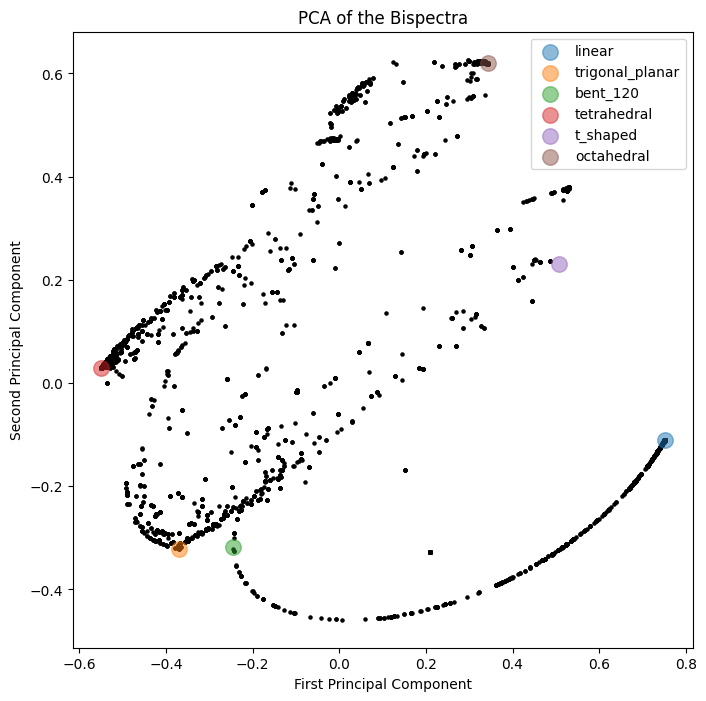

In [ ]:
for i in range(len(AgS_only_bispectra)):
    AgS_only_bispectra[i] = AgS_only_bispectra[i] / np.linalg.norm(AgS_only_bispectra[i])

pca = PCA(n_components=2)
pca_result = pca.fit_transform(AgS_only_bispectra)

plt.figure(figsize=(8, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=['black'], s=5)
plt.title('PCA of the Bispectra')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')




for label, geometry in common_geometries.items():
    pca_result = pca.transform([geometry])[0]
    plt.scatter(pca_result[0], pca_result[1], marker='.', s=500, alpha=0.5, label=f"{label}")

plt.legend()


In [ ]:
os.chdir('/Users/tphung/Dropbox (MIT)/repos/pyspectra/figures')

import plotly.graph_objects as go
import plotly.offline as py

for i in range(len(AgS_only_bispectra)):
    AgS_only_bispectra[i] = AgS_only_bispectra[i] / np.linalg.norm(AgS_only_bispectra[i])

pca = PCA(n_components=3)
pca_result = pca.fit_transform(AgS_only_bispectra)

fig = go.Figure(data=[go.Scatter3d(
    x=pca_result[:, 0], 
    y=pca_result[:, 1], 
    z=pca_result[:, 2], 
    mode='markers',
    marker=dict(
        size=2,
        color='black',                # set color to an array/list of desired values
        opacity=0.8
    )
)])

plot_range = [-0.5, 0.5]
layout = go.Layout(
    scene=dict(
        xaxis=dict(
            title='', 
            showticklabels=False, 
            # showgrid=False, 
            # zeroline=False, 
            backgroundcolor='rgba(255,255,255,255)', 
            range=plot_range
        ),
        yaxis=dict(
            title='', 
            showticklabels=False, 
            # showgrid=False, 
            # zeroline=False, 
            backgroundcolor='rgba(255,255,255,255)', 
            range=plot_range
        ),
        zaxis=dict(
            title='', 
            showticklabels=False, 
            # showgrid=False, 
            # zeroline=False, 
            backgroundcolor='rgba(255,255,255,255)', 
            range=plot_range
        ),
        bgcolor='rgba(255,255,255,255)',
        camera=dict(
            eye=dict(x=0, y=0, z=2),  # Changed the camera position to look down on the x and y axes
            up=dict(x=0, y=1, z=0)
        )
    ),
    plot_bgcolor='rgba(255,255,255,255)',
    paper_bgcolor='rgba(255,255,255,255)',
    margin=dict(l=0, r=0, t=0, b=0),
)


fig.update_layout(layout)
py.plot(fig, filename='3D_PCA_plot.html')


'3D_PCA_plot.html'

In [ ]:
def rotation_matrix(axis, theta):
    return scipy.linalg.expm(np.cross(np.eye(3), axis * theta))

def oct_to_trig(t):
    octa = np.array([
        [0.5, 0.5, 0.],
        [0.5, 0.5, 1.],
        [0., 0.5, 0.5],
        [1., 0.5, 0.5],
        [0.5, 0., 0.5],
        [0.5, 1., 0.5],
    ])
    octa = octa - octa.mean(0, keepdims=True)
    octa /= np.linalg.norm(octa, keepdims=True, axis=-1)
    
    # t = 0 -> oct
    # t = 1 -> trig
    rot_theta = np.pi / 6. * t
    
    # vector along current vertex
    vector_1 = np.array([1.,1.,1.])
    vector_1 /= np.linalg.norm(vector_1)
    # vector along desired vertex
    vector_2 = np.array([0.,0.,1.])
    # get rotation axis from cross product
    axis = np.cross(vector_1, vector_2)
    norm_axis = np.linalg.norm(axis)
    theta = np.arcsin(norm_axis) #  / (2 * np.pi)
    # print(theta / (2 * np.pi))

    rot_oct_matrix = rotation_matrix(axis / norm_axis, theta)
    rotated_octahedron = np.einsum('ix,xy->iy', octa, rot_oct_matrix)

    upper = rotated_octahedron[np.where(rotated_octahedron[:,2] > 0)]
    lower = rotated_octahedron[np.where(rotated_octahedron[:,2] <= 0)]

    rotated_octahedron = np.concatenate([upper, lower], axis=0)
    
    twist = rotation_matrix(np.array([0., 0., 1.]), rot_theta)
    negative_twist = rotation_matrix(np.array([0., 0., 1.]), -rot_theta)
    
    twist_upper = np.einsum('ix,xy->iy', upper, twist)
    twist_lower = np.einsum('ix,xy->iy', lower, negative_twist)
    
    return np.concatenate((twist_upper, twist_lower), axis=0)

oct_trig = np.array([oct_to_trig(i) for i in np.linspace(0, 1, 50)])


def tetra_to_seesaw(t):
    upper_scale = (1 - t) / 1
    lower_scale = 1 / (1 - t)
    return np.array([
        [-0.57735027 * lower_scale, -0.57735027 * lower_scale, -0.57735027],
        [ 0.57735027 * lower_scale,  0.57735027 * lower_scale, -0.57735027],
        [ 0.57735027 * upper_scale, -0.57735027 * upper_scale,  0.57735027],
        [-0.57735027 * upper_scale,  0.57735027 * upper_scale,  0.57735027],])

scale = 1.5
tetra_seesaw = np.array([tetra_to_seesaw(i) * scale  for i in np.linspace(0, 0.5, 50)])


def tetra_to_square(t):
    axis = np.array([0, 0, 1])
    theta = t * np.pi / 4
    p_rot = rotation_matrix(axis,  theta)
    n_rot = rotation_matrix(axis, -theta)
    tetra = np.array([
        [-0.57735027, -0.57735027, -0.57735027],
        [ 0.57735027,  0.57735027, -0.57735027],
        [ 0.57735027, -0.57735027,  0.57735027],
        [-0.57735027,  0.57735027,  0.57735027],
    ])
    return np.concatenate([
        np.einsum('yx,nx->ny', p_rot, tetra[:2]),
        np.einsum('yx,nx->ny', n_rot, tetra[2:])
    ], axis=0)

scale = 1.5
tetra_square = np.array([tetra_to_square(i) * scale  for i in np.linspace(0, 1, 50)])








In [ ]:
spectra.visualize_geometry(tetra_seesaw[0])

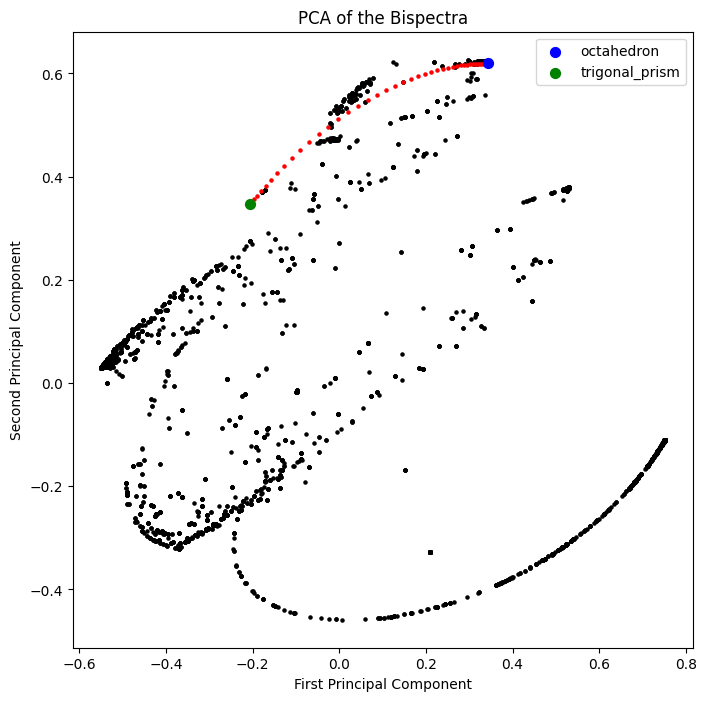

In [ ]:
bispectrum = spectra.Spectra()
oct_trig_bispectra = np.array([bispectrum.compute_geometry_spectra(geometry) for geometry in oct_trig])

for i in range(len(oct_trig_bispectra)):
    oct_trig_bispectra[i] = oct_trig_bispectra[i] / np.linalg.norm(oct_trig_bispectra[i])

pca = PCA(n_components=2)
pca_result = pca.fit_transform(AgS_only_bispectra)
pca_oct_trig = pca.transform(oct_trig_bispectra)

plt.figure(figsize=(8, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=['black'], s=5)
plt.title('PCA of the Bispectra')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

plt.scatter(pca_oct_trig[:, 0], pca_oct_trig[:, 1], c='red', s=5)

plt.scatter(pca_oct_trig[0, 0], pca_oct_trig[0, 1], c='blue', s=50, label='octahedron')
plt.scatter(pca_oct_trig[-1, 0], pca_oct_trig[-1, 1], c='green', s=50, label='trigonal_prism')



plt.legend()


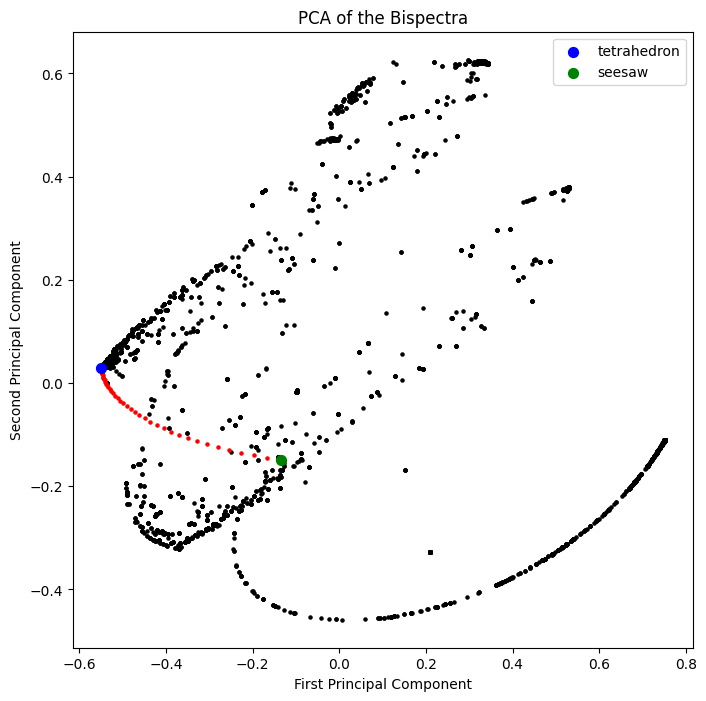

In [ ]:
bispectrum = spectra.Spectra()
tetra_seesaw_bispectra = np.array([bispectrum.compute_geometry_spectra(geometry) for geometry in tetra_seesaw])

for i in range(len(tetra_seesaw_bispectra)):
    tetra_seesaw_bispectra[i] = tetra_seesaw_bispectra[i] / np.linalg.norm(tetra_seesaw_bispectra[i])

pca = PCA(n_components=2)
pca_result = pca.fit_transform(AgS_only_bispectra)
pca_tetra_seesaw = pca.transform(tetra_seesaw_bispectra)

plt.figure(figsize=(8, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=['black'], s=5)
plt.title('PCA of the Bispectra')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

plt.scatter(pca_tetra_seesaw[:, 0], pca_tetra_seesaw[:, 1], c='red', s=5)

plt.scatter(pca_tetra_seesaw[0, 0], pca_tetra_seesaw[0, 1], c='blue', s=50, label='tetrahedron')
plt.scatter(pca_tetra_seesaw[-1, 0], pca_tetra_seesaw[-1, 1], c='green', s=50, label='seesaw')



plt.legend()


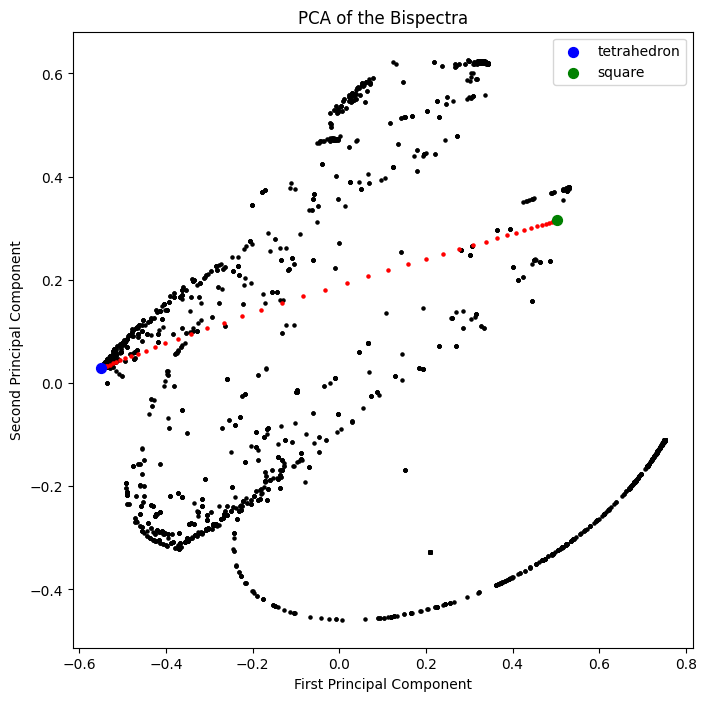

In [ ]:
bispectrum = spectra.Spectra()
tetra_square_bispectra = np.array([bispectrum.compute_geometry_spectra(geometry) for geometry in tetra_square])

for i in range(len(tetra_square_bispectra)):
    tetra_square_bispectra[i] = tetra_square_bispectra[i] / np.linalg.norm(tetra_square_bispectra[i])

pca = PCA(n_components=2)
pca_result = pca.fit_transform(AgS_only_bispectra)
pca_tetra_square = pca.transform(tetra_square_bispectra)

plt.figure(figsize=(8, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=['black'], s=5)
plt.title('PCA of the Bispectra')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

plt.scatter(pca_tetra_square[:, 0], pca_tetra_square[:, 1], c='red', s=5)

plt.scatter(pca_tetra_square[0, 0], pca_tetra_square[0, 1], c='blue', s=50, label='tetrahedron')
plt.scatter(pca_tetra_square[-1, 0], pca_tetra_square[-1, 1], c='green', s=50, label='square')



plt.legend()
